In [17]:
import pandas as pd
import numpy as np
import sklearn

In [18]:
URL = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
df = pd.read_csv(URL)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [19]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_set.drop('median_house_value', axis=1)
y = train_set['median_house_value']

X_num = X_train.drop('ocean_proximity', axis=1)

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_IX, bedrooms_IX, population_IX, households_IX = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_IX]/X[:, households_IX]
        population_per_household = X[:, households_IX]/X[:, population_IX]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_IX]/X[:, rooms_IX]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attributers', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])


In [22]:
from sklearn.compose import ColumnTransformer

num_attribs = list(X_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [23]:
X_prepared = full_pipeline.fit_transform(X_train)

In [24]:
X_prepared

array([[ 1.27258656, -1.3728112 ,  0.34849025, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.70916212, -0.87669601,  1.61811813, ...,  0.        ,
         0.        ,  1.        ],
       [-0.44760309, -0.46014647, -1.95271028, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.59946887, -0.75500738,  0.58654547, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41489815,  0.99543676,  1.85617335, ...,  0.        ,
         1.        ,  0.        ]])

Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()

In [26]:
LR_model.fit(X_prepared, y)

LinearRegression()

In [27]:
test_data = X_train.sample(1000, random_state=42)
test_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
2071,-119.85,36.74,35.0,1191.0,190.0,537.0,182.0,3.5375,INLAND
2612,-124.16,41.02,23.0,1672.0,385.0,1060.0,390.0,2.1726,NEAR OCEAN
10838,-117.92,33.67,14.0,6224.0,1679.0,3148.0,1589.0,4.2071,<1H OCEAN
4061,-118.45,34.15,10.0,1091.0,260.0,517.0,266.0,4.1727,<1H OCEAN
10767,-117.90,33.63,28.0,2370.0,352.0,832.0,347.0,7.1148,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
7192,-118.18,34.03,26.0,859.0,255.0,835.0,232.0,1.1929,<1H OCEAN
9120,-118.10,34.58,32.0,1489.0,306.0,774.0,267.0,3.2750,INLAND
6468,-118.05,34.10,42.0,2065.0,404.0,1313.0,402.0,4.0179,INLAND
672,-122.16,37.70,36.0,1719.0,303.0,836.0,311.0,4.4375,NEAR BAY


In [28]:
test_label = y.loc[test_data.index]
test_label

2071      96700.0
2612      75500.0
10838    430900.0
4061     332600.0
10767    500001.0
           ...   
7192     143800.0
9120     103500.0
6468     274300.0
672      193500.0
5977     212300.0
Name: median_house_value, Length: 1000, dtype: float64

In [29]:
test_data_prepared = full_pipeline.transform(test_data)
predicted_labels = LR_model.predict(test_data_prepared)
predicted_labels

array([ 1.35346976e+05,  1.20622245e+05,  2.86068959e+05,  2.61810384e+05,
        3.62384549e+05,  2.01854625e+05,  1.68689698e+05,  9.77728773e+04,
        2.26731462e+05,  4.56105751e+04,  1.70137429e+05,  1.23442452e+05,
        9.98822630e+04,  2.52928353e+05,  2.21991872e+05,  1.57844254e+05,
        1.77724570e+05,  1.85325354e+05,  2.66580540e+05,  1.15704487e+05,
        4.24408670e+05,  1.81751612e+05,  5.30314736e+04,  2.07894301e+05,
        1.77656964e+05,  3.97526322e+05,  3.10083194e+05,  1.44193259e+05,
        1.19710517e+05,  1.88265507e+05,  1.81722283e+05,  1.96599468e+05,
        1.22546866e+05,  1.75438107e+05,  2.91082427e+05,  3.62776360e+05,
        2.96822733e+05,  2.23501781e+05,  1.52254641e+05,  2.13793411e+05,
        3.23964883e+05,  1.92747706e+05,  8.02544844e+04,  7.45782606e+04,
        5.39124864e+04,  2.15598928e+05,  2.37983330e+05,  2.56771176e+05,
        6.55268360e+05,  2.49767990e+05,  2.48795781e+05,  3.19246723e+05,
        2.68476659e+05,  

In [30]:
tp_data = pd.DataFrame({"Actual": test_label, "Predicted": predicted_labels})
tp_data

,Actual,Predicted
2071,96700.0,135346.975568
2612,75500.0,120622.245375
10838,430900.0,286068.958778
4061,332600.0,261810.384314
10767,500001.0,362384.548708
...,...,...
7192,143800.0,95702.108857
9120,103500.0,141813.561389
6468,274300.0,181533.238406
672,193500.0,248033.763921


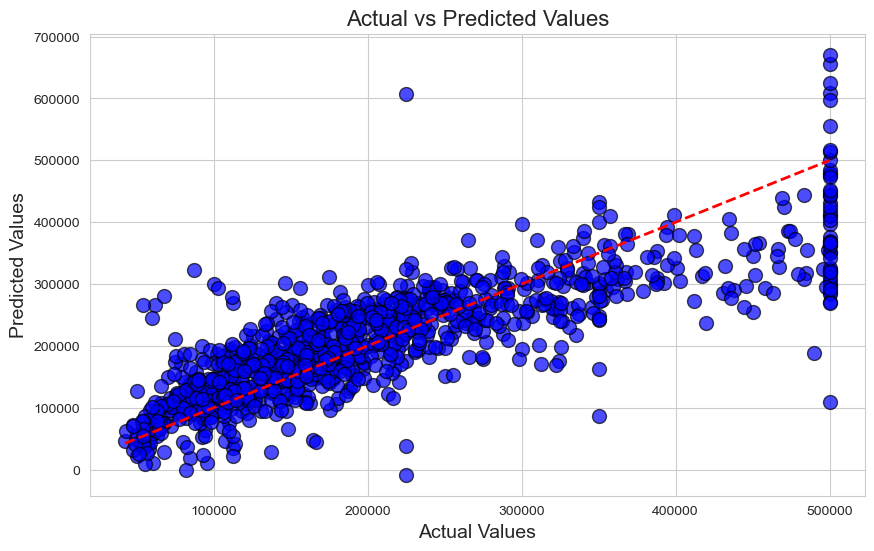

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tp_data['Actual'], tp_data['Predicted'], color='b', edgecolor='k', alpha=0.7, s=100)

# Plotting the line of perfect prediction
plt.plot([tp_data['Actual'].min(), tp_data['Actual'].max()], [tp_data['Actual'].min(), tp_data['Actual'].max()], 'r--', lw=2)

# Adding titles and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)

# Adding a grid
plt.grid(True)

# Show the plot
plt.show()

In [32]:
test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
15362,-117.22,33.36,16.0,3165.0,482.0,1351.0,452.0,4.6050,263300.0,<1H OCEAN
16623,-120.83,35.36,28.0,4323.0,886.0,1650.0,705.0,2.7266,266800.0,NEAR OCEAN
18086,-122.05,37.31,25.0,4111.0,538.0,1585.0,568.0,9.2298,500001.0,<1H OCEAN
2144,-119.76,36.77,36.0,2507.0,466.0,1227.0,474.0,2.7850,72300.0,INLAND


In [33]:
X_test = test_set.drop('median_house_value', axis=1)
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
15362,-117.22,33.36,16.0,3165.0,482.0,1351.0,452.0,4.6050,<1H OCEAN
16623,-120.83,35.36,28.0,4323.0,886.0,1650.0,705.0,2.7266,NEAR OCEAN
18086,-122.05,37.31,25.0,4111.0,538.0,1585.0,568.0,9.2298,<1H OCEAN
2144,-119.76,36.77,36.0,2507.0,466.0,1227.0,474.0,2.7850,INLAND


In [34]:
y_test = test_set['median_house_value'].copy()
y_test

20046     47700.0
3024      45800.0
15663    500001.0
20484    218600.0
9814     278000.0
           ...   
15362    263300.0
16623    266800.0
18086    500001.0
2144      72300.0
3665     151500.0
Name: median_house_value, Length: 4128, dtype: float64

In [35]:
X_test_prepared = full_pipeline.transform(X_test)

In [36]:
y_predicted = LR_model.predict(X_test_prepared)

In [37]:
y_predicted

array([ 43790.84638667, 128823.14345679, 319846.39616646, ...,
       445785.19103529, 121531.58250907, 174286.66477813])

In [39]:
# Mean absolute error and Root mean square error
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', np.sqrt(mse))

Mean Absolute Error: 48862.5317930931
Mean Squared Error: 68753.17963084123


In [44]:
# Using random forest library
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor()
RF_model.fit(X_prepared, y)

RandomForestRegressor()

In [45]:
y_predicted = RF_model.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_predicted)
print('Mean Squared Error:', np.sqrt(mse))

Mean Squared Error: 50178.27652744217


In [46]:
x = df.drop(['median_house_value'], axis=1)
y = df['median_house_value'].copy()

X_prepared = full_pipeline.fit_transform(x)

In [51]:
from sklearn.model_selection import cross_val_score

mse_scores = cross_val_score(LR_model, X_prepared, y, scoring='neg_mean_squared_error', cv=5)

In [52]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [53]:
display_scores(np.sqrt(-mse_scores))

Scores: [70707.91604323 70940.61397045 72181.23971877 73064.86625696
 66235.1226408 ]
Mean: 70625.95172604271
Standard deviation: 2355.9429264157857


In [54]:
scores = cross_val_score(RF_model, X_prepared, y, scoring='neg_mean_absolute_error', cv=10)
LR_rmse_scores = np.sqrt(-scores)
display_scores(LR_rmse_scores)

Scores: [275.75718495 185.82096651 214.72663767 194.12483835 210.62366298
 199.27150242 186.34446518 236.84617397 232.65897069 184.68498659]
Mean: 212.08593893189914
Standard deviation: 27.730043886101924


In [55]:
import pickle

filename = 'RF_model.pkl'
with open(filename, 'wb') as f:
    pickle.dump(RF_model, f)

In [56]:
with open(filename, 'rb') as f:
    model = pickle.load(f)

In [59]:
# testing the loaded model

y_predicted = model.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_predicted)
print('Mean Squared Error:', np.sqrt(mse))

Mean Squared Error: 50178.27652744217


Joblib

In [60]:
import joblib

filename = 'RF_model.jbl'
joblib.dump(LR_model, filename)


['RF_model.jbl']

In [61]:
model = joblib.load(filename)

In [63]:
y_predicted = model.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_predicted)
print('Mean Squared Error:', np.sqrt(mse))

Mean Squared Error: 68753.17963084123
